- **Problem**:

Şirketi terk edecek müşterileri tahmin edebilecek bir makine öğrenmesi modeli geliştirebilir misiniz?
Amaç bir bankanın müşterilerinin bankayı terk etme ya da terk etmeme durumunun tahmin edilmesidir.
Müşteri terkini tanımlayan olay müşterinin banka hesabını kapatmasıdır.

- **Veri Seti Hikayesi**:
10000 gözlemden ve 12 değişkenden oluşmaktadır.
Bağımsız değişkenler müşterilere ilişkin bilgiler barındırmaktadır.
Bağımlı değişken müşteri terk durumunu ifade etmektedir.
- ***Değişkenler***:
- Surname : Soy isim
- CreditScore : Kredi skoru
- Geography : Ülke (Germany/France/Spain)
- Gender : Cinsiyet (Female/Male)
- Age : Yaş
- Tenure : Kaç yıllık müşteri
- Balance : Bakiye
- NumOfProducts : Kullanılan banka ürünü
- HasCrCard : Kredi kartı durumu (0=No,1=Yes)
- IsActiveMember : Aktif üyelik durumu (0=No,1=Yes)
- EstimatedSalary : Tahmini maaş
- Exited : Terk mi değil mi? (0=No,1=Yes)

In [40]:
#Kutuphanelerin yuklenmesi
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# to display all columns and rows:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


In [41]:
df = pd.read_csv("../input/churn-123/churn kopyas.csv")
#ilk 5 satırın gozlenmesi
df.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [42]:
#Eksik deger var mı sorgulanması
df.isnull().sum()


RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [43]:
#bazı degiskenlerin dusurulmesi
need_drops = ["RowNumber", "CustomerId", "Surname"]
df.drop(need_drops, axis=1, inplace=True)

#degiskenleri kategorik ve sayısal olarak ayırma
cat = [col for col in df.columns if df[col].nunique() < 10]
num = [col for col in df.columns if df[col].nunique() >= 10 and
       df[col].dtypes != "O"]



In [44]:

#Degiskenlerin(sütunlar) normal dagılıp dagılmadıgını gosterir.
#Yapılan normallik testlerinde tüm degiskenlerin pvalue degerleri 0.05'den kucuk old. icin H0 reddedilir.
#Yani tum degiskenler normal dagılmamıstır.

for i in ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']:
    print(i)
    t_test , p_value = shapiro(df[i])
    print('Test İstatistiği = %.4f, p-değeri = %.4f' % (t_test, p_value))



CreditScore
Test İstatistiği = 0.9939, p-değeri = 0.0000
Age
Test İstatistiği = 0.9441, p-değeri = 0.0000
Tenure
Test İstatistiği = 0.9487, p-değeri = 0.0000
Balance
Test İstatistiği = 0.8456, p-değeri = 0.0000
EstimatedSalary
Test İstatistiği = 0.9566, p-değeri = 0.0000


In [45]:

#Bazı degiskenlerin unique degerlerine bakılması.

df["Geography"].nunique() # 3 tane ulke var
df["Age"].nunique()

#Tum degiskenlerin unique degerlerine bakılması
for col in df.columns:
    print(col, "unique number : ", df[col].nunique())



CreditScore unique number :  460
Geography unique number :  3
Gender unique number :  2
Age unique number :  70
Tenure unique number :  11
Balance unique number :  6382
NumOfProducts unique number :  4
HasCrCard unique number :  2
IsActiveMember unique number :  2
EstimatedSalary unique number :  9999
Exited unique number :  2


In [46]:
#Kategorik degiskenlerin ozellikleri
def cat_summary(dataframe, categorical_columns, target, plot=False):
    """
    -> Kategorik değişkenlerin sınıflarının oranını ve targettaki medyanı gösterir.
    :param dataframe: İşlem yapılacak dataframe
    :param categorical_columns: Kategorik değişkenlerin adları
    :param target: Dataframe'de ilgilendiğimiz değişken.
    :param plot: Grafik çizdirmek için argüman : True/False
    """
    for col in categorical_columns:
        print(col, " : ", dataframe[col].nunique(), " unique classes.\n")
        print(col, " : ", dataframe[col].value_counts().sum(), "\n")
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO ( % )": 100 * dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEDIAN": dataframe.groupby(col)[target].median(),
                            "TARGE_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
        if plot:
            sns.countplot(x=col, data=dataframe)
            plt.show()

cat_summary(df, cat, "Exited")




Geography  :  3  unique classes.

Geography  :  10000 

           COUNT  RATIO ( % )  TARGET_MEDIAN  TARGE_MEAN
Geography                                               
France      5014        50.14              0    0.161548
Germany     2509        25.09              0    0.324432
Spain       2477        24.77              0    0.166734


Gender  :  2  unique classes.

Gender  :  10000 

        COUNT  RATIO ( % )  TARGET_MEDIAN  TARGE_MEAN
Female   4543        45.43              0    0.250715
Male     5457        54.57              0    0.164559


NumOfProducts  :  4  unique classes.

NumOfProducts  :  10000 

   COUNT  RATIO ( % )  TARGET_MEDIAN  TARGE_MEAN
1   5084        50.84              0    0.277144
2   4590        45.90              0    0.075817
3    266         2.66              1    0.827068
4     60         0.60              1    1.000000


HasCrCard  :  2  unique classes.

HasCrCard  :  10000 

   COUNT  RATIO ( % )  TARGET_MEDIAN  TARGE_MEAN
0   2945        29.45      

In [47]:
#Histogram cizilmesi
def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].hist(bins=20)
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables have been plotted")


    
#Enkod fonksiyonun yazılması
def one_hot_encoder(dataframe, category_freq=10, nan_as_category=False):
    categorical_cols = [col for col in dataframe.columns if len(dataframe[col].value_counts()) < category_freq
                        and dataframe[col].dtypes == 'O']

    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, dummy_na=nan_as_category, drop_first=True)

    return dataframe


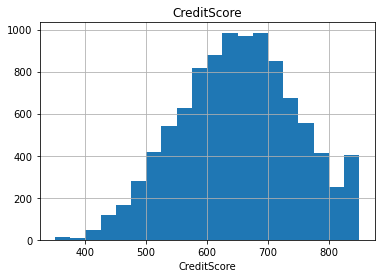

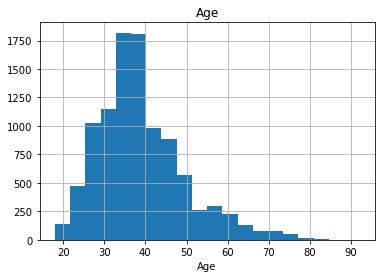

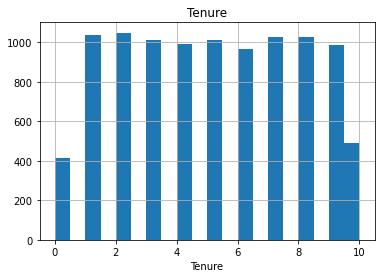

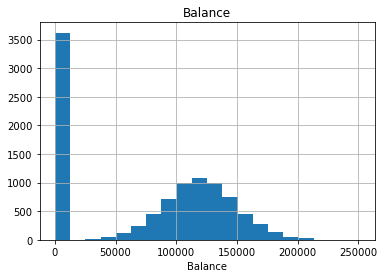

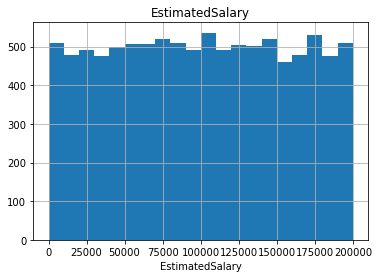

5 variables have been plotted


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0


In [48]:
#Sayısal degiskenler icin histogramın cizdirilmesi.
hist_for_nums(df, num)  

#Enkod islemi

df = one_hot_encoder(df)

#ilk iki gozlem
df.head(2)


In [49]:
#Kategorik degerler a listesinde , sayısal degiskenlerse b listesinde bulunmaktadır.
a = ["NumOfProducts","HasCrCard","Tenure","IsActiveMember","Geography_Germany","Geography_Spain","Gender_Male"]
b = ['CreditScore' , 'Age', 'Balance', 'EstimatedSalary']

# Cesitli caprazlamalarla veri setinin incelenmesi

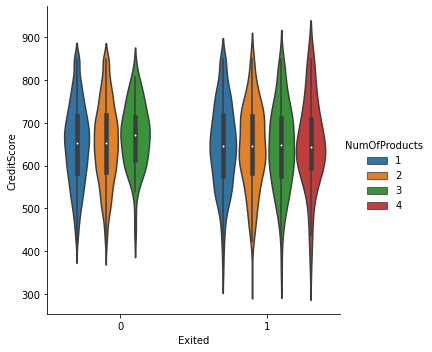

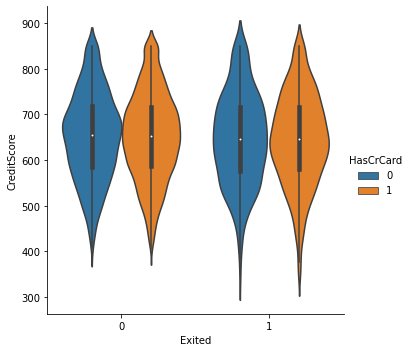

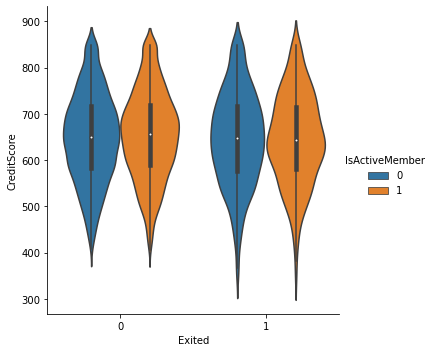

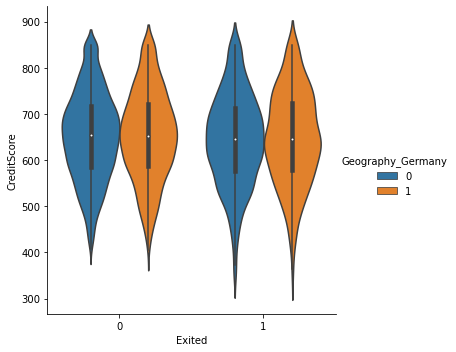

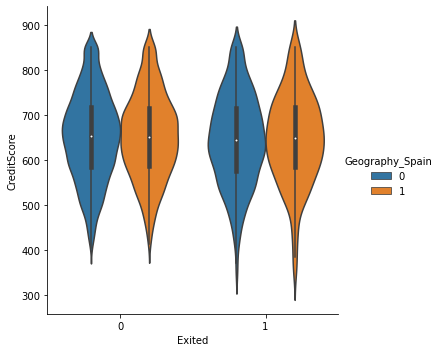

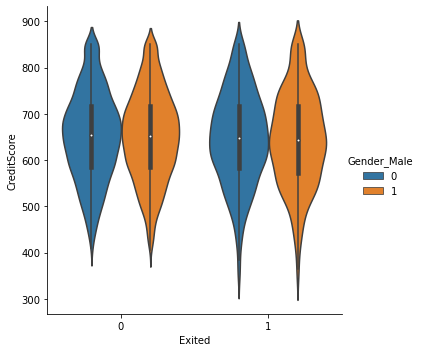

In [50]:
#Y eksenine CreditScore sabıtleyerek, x ekseninde Exited bazında tum kategorilerin gorsel olarak incelenmesi.
for i in ["NumOfProducts","HasCrCard","IsActiveMember","Geography_Germany","Geography_Spain","Gender_Male"]:
    if cat == "Exited":
        pass
    else:
        
        sns.catplot(x ="Exited" , y="CreditScore", hue = i ,data = df , kind="violin")
        plt.show()

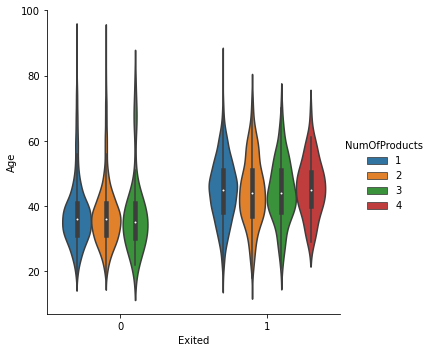

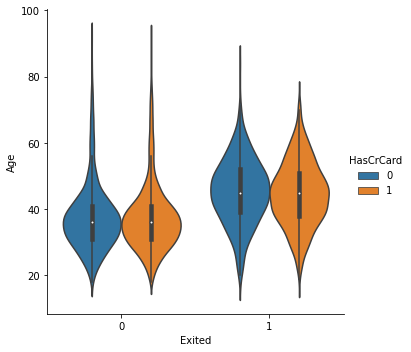

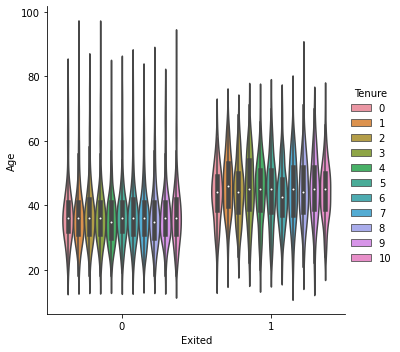

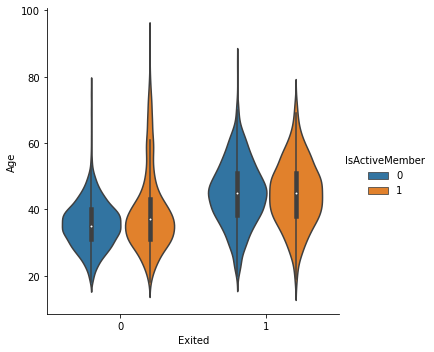

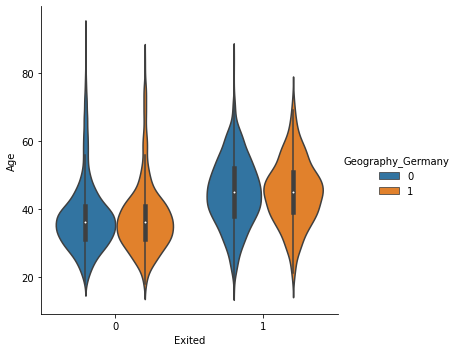

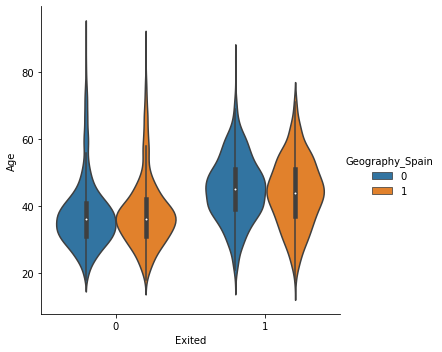

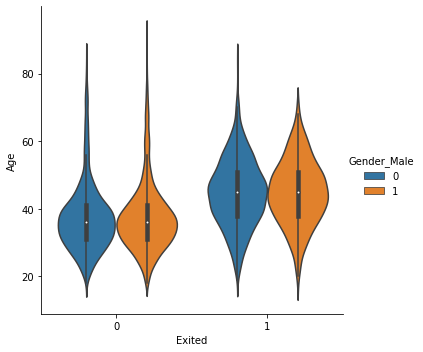

In [51]:
#Y eksenine Age sabıtleyerek, x ekseninde Exited bazında tum kategorilerin gorsel olarak incelenmesi.
for i in ["NumOfProducts","HasCrCard","Tenure","IsActiveMember","Geography_Germany","Geography_Spain","Gender_Male"]:
    if cat == "Exited":
        pass
    else:
        
        sns.catplot(x ="Exited" , y="Age", hue = i ,data = df , kind="violin")
        plt.show()

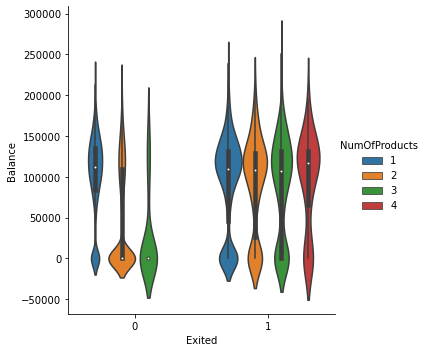

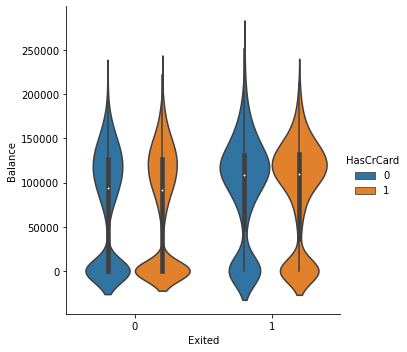

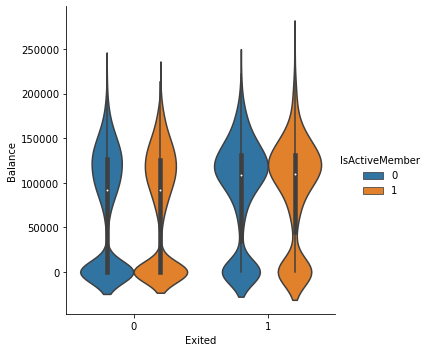

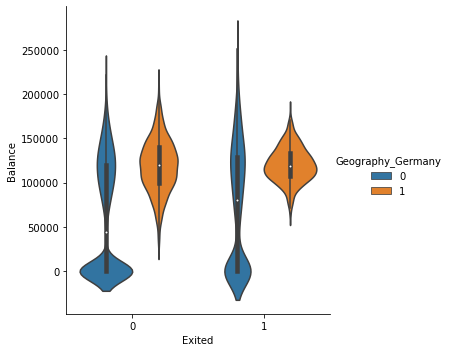

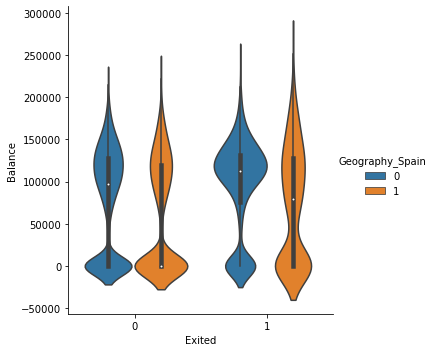

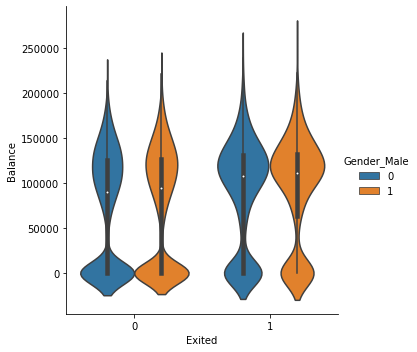

In [52]:
#Y eksenine Balance sabıtleyerek, x ekseninde Exited bazında tum kategorilerin gorsel olarak incelenmesi.
for i in ["NumOfProducts","HasCrCard","IsActiveMember","Geography_Germany","Geography_Spain","Gender_Male"]:
    if cat == "Exited":
        pass
    else:
        
        sns.catplot(x ="Exited" , y="Balance", hue = i ,data = df , kind="violin")
        plt.show()

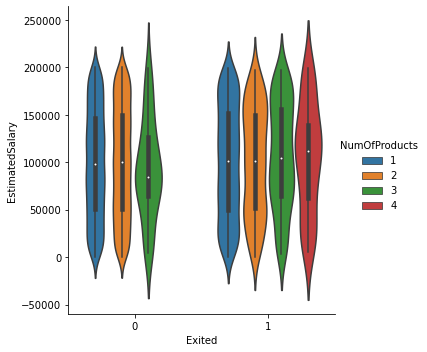

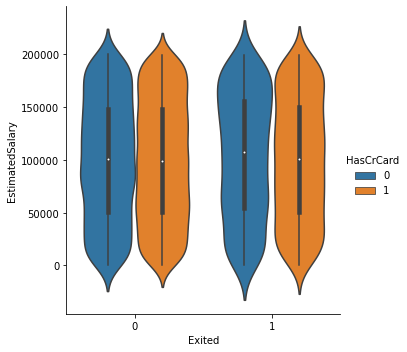

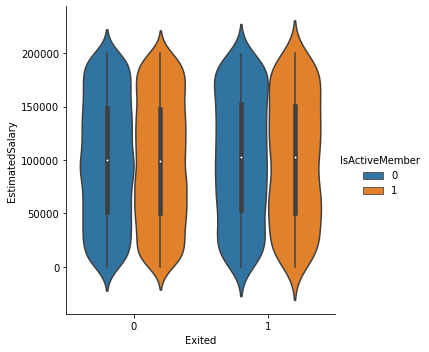

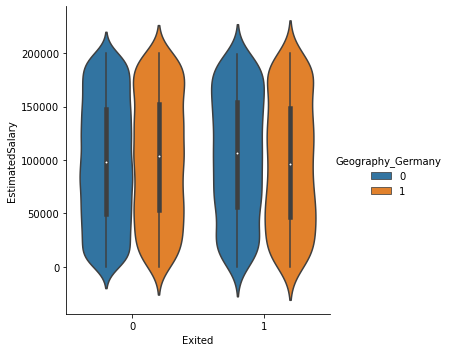

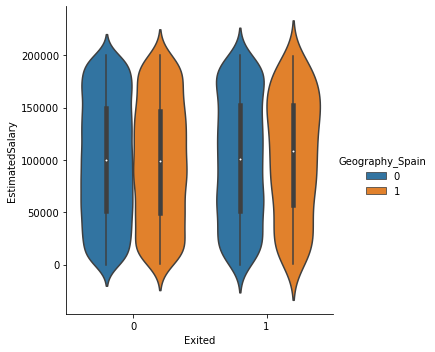

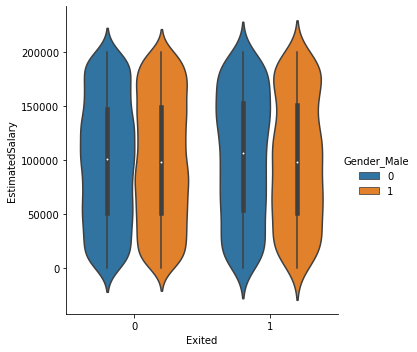

In [53]:
#Y eksenine EstimatedSalary sabıtleyerek, x ekseninde Exited bazında tum kategorilerin gorsel olarak incelenmesi.
for i in ["NumOfProducts","HasCrCard","IsActiveMember","Geography_Germany","Geography_Spain","Gender_Male"]:
    if cat == "Exited":
        pass
    else:
        
        sns.catplot(x ="Exited" , y="EstimatedSalary", hue = i ,data = df , kind="violin")
        plt.show()

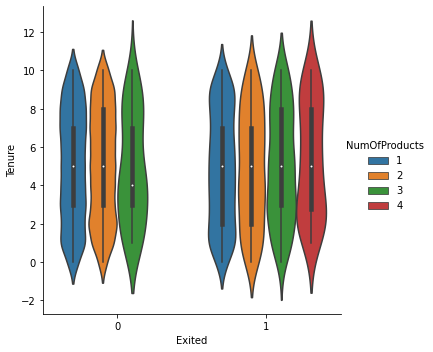

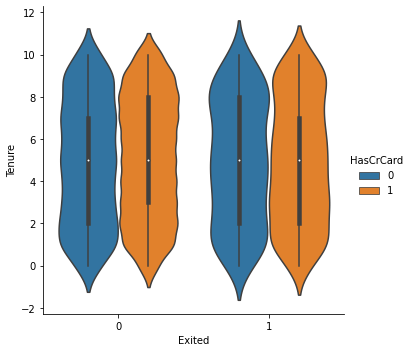

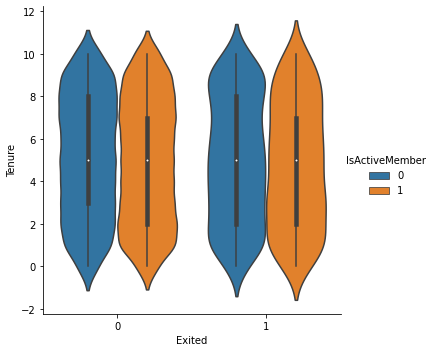

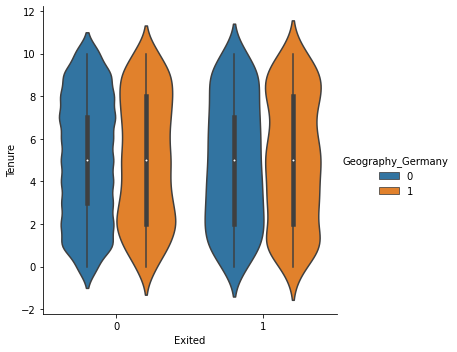

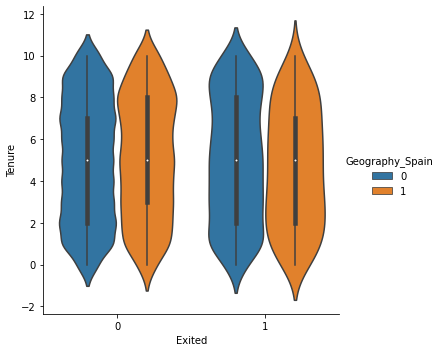

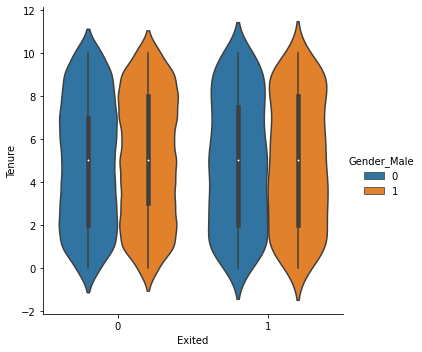

In [54]:
#Y eksenine Tenure sabıtleyerek, x ekseninde Exited bazında tum kategorilerin gorsel olarak incelenmesi.
for i in ["NumOfProducts","HasCrCard","IsActiveMember","Geography_Germany","Geography_Spain","Gender_Male"]:
    if cat == "Exited":
        pass
    else:
        
        sns.catplot(x ="Exited" , y="Tenure", hue = i ,data = df , kind="violin")
        plt.show()

In [55]:
#Korelasyonların hesaplanması
df.corr().T

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.002857
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.027544
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.000567,0.003868,0.014733
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.401110,-0.134892,0.012087
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,-0.021859
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.005766
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.022544
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.008112
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.173488,-0.052667,-0.106512
Geography_Germany,0.005538,0.046897,-0.000567,0.401110,-0.010419,0.010577,-0.020486,0.010297,0.173488,1.000000,-0.332084,-0.024628


# Yeni degisken olusturulması

In [56]:
#yeni degisken uretilmesi

df["b_a"] = (df.Age * df.Balance)

#Degiskenlere yapılan baskılama islemleri
df.Balance = (df.Balance + 1)
df.loc[(df.Exited == 0) & (df.Age > 50) , "Age"] = 50
df.loc[(df.Age < 20) , "Age"] = 20
df.loc[(df.Exited == 0) & (df.Balance > 200000) , "Balance"] = 200000
df.loc[(df.NumOfProducts == 1) & (df.NumOfProducts == 2) & (df.NumOfProducts == 3) , "NumOfProducts"] = 1
df.drop("HasCrCard" , axis = 1 , inplace=True)
df.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,b_a
0,619,42,2,1.00,1,1,101348.88,1,0,0,0,0.00
1,608,41,1,83808.86,1,1,112542.58,0,0,1,0,3436122.26


# Modelleme

In [57]:
#Exited degiskeninin dusurulmesi
X = df.drop('Exited', axis=1)
y = df[["Exited"]]

#Veri setinin egitim ve test seti olarak bolunmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y , random_state=46)


In [58]:
# LightGBM

#Model olusturma
lgbm = LGBMClassifier(random_state=12345)
cross_val_score(lgbm, X, y, cv=10).mean()

# model tuning
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1000],
               "max_depth": [3, 5]}

#GridSearchCV hesaplanması
gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv=5,
                     n_jobs=-1,
                     verbose=2).fit(X, y)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   18.5s finished


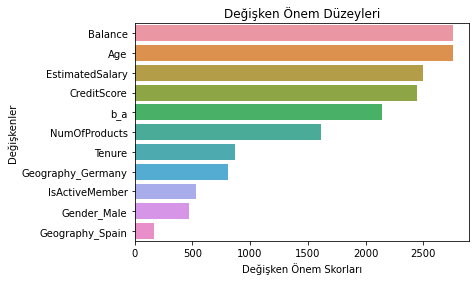

In [59]:
#En iyi parametrelerle model kurma
lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X_train, y_train)
cross_val_score(lgbm_tuned, X_test, y_test, cv=10).mean()


feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

#Degisken onem duzeylerinin grafiksel gosterimi
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Değişken Önem Skorları')
plt.ylabel('Değişkenler')
plt.title("Değişken Önem Düzeyleri")
plt.show()

#cv islemleri(caprazlama)
kfold = KFold(n_splits=10, random_state=123456)
cv_results = cross_val_score(LGBMClassifier(), X_train, y_train, cv=kfold, scoring="accuracy")


**Sınıflandırma Sonucu**

In [60]:
cv_results.mean()

0.882625